In [84]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import figure
from datetime import datetime
pd.set_option('display.max_colwidth', None)

In [37]:
releases_raw = pd.read_csv('../data/csv/releases.csv')
imports = pd.read_csv('../data/csv/imports.csv')
import_diffs = pd.read_csv('../data/csv/import_diffs.csv')
repo_imports = pd.read_csv('../data/csv/repo_imports.csv')
repo_import_diffs = pd.read_csv('../data/csv/repo_import_diffs.csv')
repo_import_diffs_timeline = pd.read_csv('../data/csv/repo_import_diffs_timeline.csv')

In [76]:
ml_libraries = ["tensorflow", "torch", "theano", "keras"]

ml_imports = imports[imports['name'].isin(ml_libraries)]
ml_imports_diffs = import_diffs[import_diffs['import_name'].isin(ml_libraries)]
ml_repo_imports = repo_imports[repo_imports['import_name'].isin(ml_libraries)]
ml_repo_import_diffs = repo_import_diffs[repo_import_diffs['import_name'].isin(ml_libraries)]
ml_repo_import_diffs_timeline = pd.DataFrame(
    repo_import_diffs_timeline[repo_import_diffs_timeline['import'].isin(ml_libraries)]
)

Transform Releases data

In [77]:
releases_raw['date'] = pd.to_datetime(releases_raw['date_time'])
releases = releases_raw.drop(columns=['year', 'month', 'day', 'time', 'date_time'])
# releases.sort_values(by="date")

ml_repo_import_diffs_timeline['date'] = pd.to_datetime(ml_repo_import_diffs_timeline['date'])

In [36]:
ml_repo_imports.head()

,repo,version,import_name,import_asname,import_module
0,google/tangent,v0.1.4,tensorflow,tf,NaN
1,google/tangent,v0.1.6,tensorflow,tf,NaN
2,google/tangent,v0.1.7,tensorflow,tf,NaN
3,google/tangent,v0.1.8,tensorflow,tf,NaN
4,google/tangent,v0.1.9,tensorflow,tf,NaN


In [79]:
ml_repo_import_diffs_timeline.head(80)


,date,import,count
0,2015-06-13,theano,1
1,2015-06-13,keras,1
3,2015-07-18,theano,1
4,2015-07-18,keras,1
8,2015-08-27,theano,1
...,...,...,...
422,2018-07-06,theano,1
423,2018-07-06,keras,3
429,2018-07-06,tensorflow,5
443,2018-07-06,torch,1


In [80]:
theano_counts = ml_repo_import_diffs_timeline[ml_repo_import_diffs_timeline['import'] == 'theano']
tensorflow_counts = ml_repo_import_diffs_timeline[ml_repo_import_diffs_timeline['import'] == 'tensorflow']
torch_counts = ml_repo_import_diffs_timeline[ml_repo_import_diffs_timeline['import'] == 'torch']
keras_counts = ml_repo_import_diffs_timeline[ml_repo_import_diffs_timeline['import'] == 'keras']

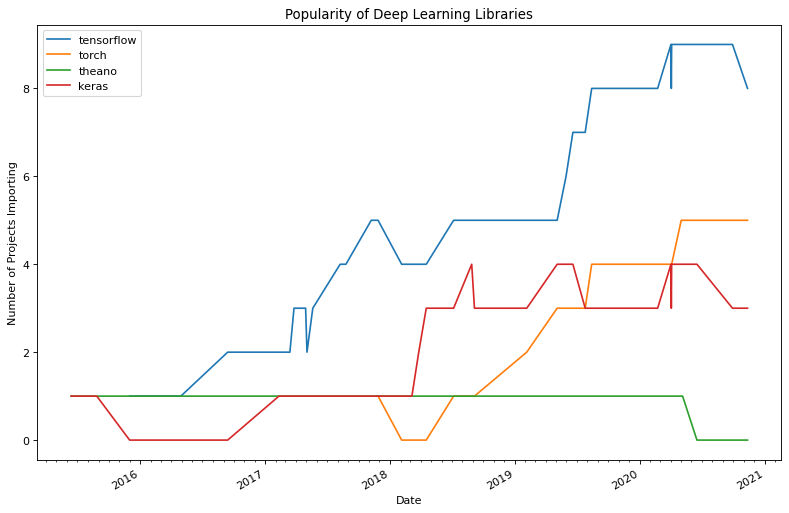

In [93]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 80 # 200 e.g. is really fine, but slower

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')
fig, ax = plt.subplots()

ax.plot(tensorflow_counts['date'], tensorflow_counts['count'], label='tensorflow')
ax.plot(torch_counts['date'], torch_counts['count'], label='torch')
ax.plot(theano_counts['date'], theano_counts['count'], label='theano')
ax.plot(keras_counts['date'], keras_counts['count'], label='keras')

ax.set_xlabel('Date')
ax.set_ylabel('Number of Projects Importing')
ax.set_title('Popularity of Deep Learning Libraries')
ax.legend()

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)
                           
# datemin = datetime.date(ml_repo_import_diffs_timeline['date'].min().year, 1, 1)
# datemax = datetime.date(ml_repo_import_diffs_timeline['date'].max().year + 1, 1, 1)
# ax.set_xlim(datemin, datemax)

fig.autofmt_xdate()

plt.show()
